# 28: VAE z=8 Fisher Overlap Analysis

Notebook 26 computed Fisher overlap for the default VAE architecture (latent_dim=32).
This notebook trains a VAE with latent_dim=8 (same hidden layer dimensions) and
repeats the Fisher overlap analysis to assess whether the overlap pattern is
sensitive to the choice of latent dimension.

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

from vae import VAE, vae_loss
from fisher_utils import (
    AnnDataDataset, compute_vae_fisher,
    cosine_sim, effective_rank, top_k_overlap,
    vae_layer_category,
)

matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 0.8

OUTPUTS = Path('../outputs')
FIGURES = Path('../figures')
FIGURES.mkdir(exist_ok=True)
(OUTPUTS / 'p6').mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1. Load data and splits

In [2]:
adata = sc.read_h5ad('../data/adata_processed.h5ad')
print(f'Data: {adata.shape}')

with open(OUTPUTS / 'p1' / 'split_structured.json') as f:
    split = json.load(f)
forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']
all_train_idx = forget_idx + retain_idx
print(f'Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}')
print(f'Train: {len(all_train_idx)}, Val: {len(unseen_idx)}')

Data: (33088, 2000)
Forget: 30, Retain: 28094, Unseen: 4964
Train: 28124, Val: 4964


## 2. Create datasets and dataloaders

In [3]:
train_ds = AnnDataDataset(adata, all_train_idx)
val_ds = AnnDataDataset(adata, unseen_idx)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}')

Train batches: 110, Val batches: 20


## 3. Initialize VAE with z=8

In [4]:
torch.manual_seed(42)
np.random.seed(42)

model = VAE(
    input_dim=2000,
    hidden_dims=[1024, 512, 128],
    latent_dim=8,
    likelihood='nb',
    dropout=0.1,
    use_layer_norm=True
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f'VAE (z=8): {n_params:,} params')
print()
for name, param in model.named_parameters():
    cat = vae_layer_category(name)
    print(f'  {name:50s} {str(list(param.shape)):20s} {param.numel():>10,d}  [{cat}]')

VAE (z=8): 7,340,720 params

  encoder.network.0.weight                           [1024, 2000]          2,048,000  [Encoder]
  encoder.network.0.bias                             [1024]                    1,024  [Encoder]
  encoder.network.1.weight                           [1024]                    1,024  [Encoder]
  encoder.network.1.bias                             [1024]                    1,024  [Encoder]
  encoder.network.4.weight                           [512, 1024]             524,288  [Encoder]
  encoder.network.4.bias                             [512]                       512  [Encoder]
  encoder.network.5.weight                           [512]                       512  [Encoder]
  encoder.network.5.bias                             [512]                       512  [Encoder]
  encoder.network.8.weight                           [128, 512]               65,536  [Encoder]
  encoder.network.8.bias                             [128]                       128  [Encoder]
  encoder.n

## 4. Train VAE with validation early stopping

In [5]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_state = None
best_epoch = 0
start_time = time.time()

for epoch in range(100):
    # Train
    model.train()
    train_loss = 0
    n_train = 0
    for x_batch, lib_batch in train_loader:
        x_batch, lib_batch = x_batch.to(device), lib_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch, library_size=lib_batch)
        loss, recon, kl = vae_loss(x_batch, output, likelihood='nb', library_size=lib_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(x_batch)
        n_train += len(x_batch)

    # Validate
    model.train(False)
    val_loss = 0
    n_val = 0
    with torch.no_grad():
        for x_batch, lib_batch in val_loader:
            x_batch, lib_batch = x_batch.to(device), lib_batch.to(device)
            output = model(x_batch, library_size=lib_batch)
            loss, _, _ = vae_loss(x_batch, output, likelihood='nb', library_size=lib_batch)
            val_loss += loss.item() * len(x_batch)
            n_val += len(x_batch)

    avg_train = train_loss / n_train
    avg_val = val_loss / n_val
    train_losses.append(avg_train)
    val_losses.append(avg_val)

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        best_state = {k: v.clone() for k, v in model.state_dict().items()}
        best_epoch = epoch + 1

    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1:3d}: train={avg_train:.2f}, val={avg_val:.2f}, best={best_val_loss:.2f} (ep {best_epoch})')

elapsed = time.time() - start_time
print(f'\nTraining took {elapsed:.0f}s')
print(f'Best val loss: {best_val_loss:.2f} at epoch {best_epoch}')

  Epoch  10: train=373.82, val=370.93, best=370.93 (ep 10)
  Epoch  20: train=370.23, val=368.75, best=368.66 (ep 19)
  Epoch  30: train=368.74, val=367.63, best=367.63 (ep 30)
  Epoch  40: train=367.84, val=367.12, best=367.10 (ep 37)
  Epoch  50: train=367.18, val=366.92, best=366.82 (ep 48)
  Epoch  60: train=366.72, val=366.59, best=366.44 (ep 56)
  Epoch  70: train=366.28, val=366.60, best=366.42 (ep 63)
  Epoch  80: train=365.90, val=366.33, best=366.27 (ep 77)
  Epoch  90: train=365.61, val=366.39, best=366.27 (ep 77)
  Epoch 100: train=365.20, val=366.64, best=366.27 (ep 77)

Training took 1501s
Best val loss: 366.27 at epoch 77


## 5. Training curves

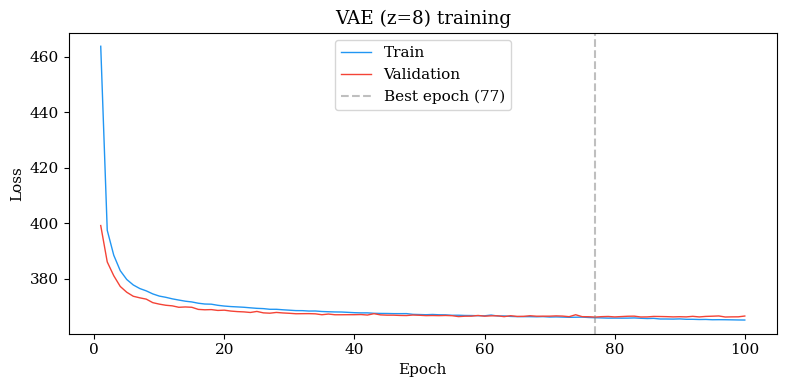

Saved to ../figures/vae_z8_training.png


In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

epochs = range(1, len(train_losses) + 1)
ax.plot(epochs, train_losses, color='#2196F3', linewidth=1, label='Train')
ax.plot(epochs, val_losses, color='#F44336', linewidth=1, label='Validation')
ax.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.5,
           label=f'Best epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('VAE (z=8) training')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES / 'vae_z8_training.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "vae_z8_training.png"}')

## 6. Save checkpoint and load best model

In [7]:
model.load_state_dict(best_state)

torch.save({
    'model_state_dict': best_state,
    'config': {
        'input_dim': 2000, 'latent_dim': 8,
        'hidden_dims': [1024, 512, 128],
        'likelihood': 'nb', 'dropout': 0.1,
        'use_layer_norm': True
    },
    'val_loss': best_val_loss,
}, OUTPUTS / 'p6' / 'vae_z8_best_model.pt')
print(f'Checkpoint saved to {OUTPUTS / "p6" / "vae_z8_best_model.pt"}')

Checkpoint saved to ../outputs/p6/vae_z8_best_model.pt


## 7. Compute Fisher on forget and retain subsets

In [8]:
forget_ds = AnnDataDataset(adata, forget_idx)
retain_ds = AnnDataDataset(adata, retain_idx)
forget_loader = DataLoader(forget_ds, batch_size=128, shuffle=False)
retain_loader = DataLoader(retain_ds, batch_size=256, shuffle=False)

print('Computing forget-set Fisher...')
fisher_forget, n_f = compute_vae_fisher(model, forget_loader, device)
print(f'  {n_f} samples')

print('Computing retain-set Fisher...')
fisher_retain, n_r = compute_vae_fisher(model, retain_loader, device)
print(f'  {n_r} samples')

Computing forget-set Fisher...
  30 samples
Computing retain-set Fisher...
  28094 samples


## 8. Per-layer analysis

In [9]:
print(f'{"Layer":50s} {"Params":>10s} {"Cosine":>8s} {"EffRank(F)":>12s} {"EffRank(R)":>12s} {"Category"}')
print('-' * 110)

layer_data = []
categories = {}

for name in fisher_forget:
    ff = fisher_forget[name].flatten()
    fr = fisher_retain[name].flatten()
    n = len(ff)
    if n < 10:
        continue
    cos = cosine_sim(ff, fr)
    er_f = effective_rank(ff)
    er_r = effective_rank(fr)
    cat = vae_layer_category(name)
    layer_data.append({
        'name': name, 'n_params': n, 'cosine': cos,
        'eff_rank_f': er_f, 'eff_rank_r': er_r, 'category': cat
    })
    if cat not in categories:
        categories[cat] = {'f': [], 'r': []}
    categories[cat]['f'].append(ff)
    categories[cat]['r'].append(fr)
    print(f'{name:50s} {n:10,d} {cos:8.4f} {er_f:12.0f} {er_r:12.0f} {cat}')

Layer                                                  Params   Cosine   EffRank(F)   EffRank(R) Category
--------------------------------------------------------------------------------------------------------------
encoder.network.0.weight                            2,048,000   0.1825        36747       178615 Encoder
encoder.network.0.bias                                  1,024   0.2135          161          567 Encoder
encoder.network.1.weight                                1,024   0.7182           78          157 Encoder
encoder.network.1.bias                                  1,024   0.2437          178          735 Encoder
encoder.network.4.weight                              524,288   0.2136        18002       230400 Encoder
encoder.network.4.bias                                    512   0.4040           94          401 Encoder
encoder.network.5.weight                                  512   0.2538           70          345 Encoder
encoder.network.5.bias                          

## 9. Global and per-category metrics

In [10]:
# Global metrics
ff_global = torch.cat([f.flatten() for f in fisher_forget.values()])
fr_global = torch.cat([f.flatten() for f in fisher_retain.values()])
global_cos = cosine_sim(ff_global, fr_global)
log_corr = torch.corrcoef(
    torch.stack([ff_global.log(), fr_global.log()])
)[0, 1].item()
n_total = len(ff_global)
top1 = top_k_overlap(ff_global, fr_global, int(0.01 * n_total))
top10 = top_k_overlap(ff_global, fr_global, int(0.1 * n_total))

print(f'Global cosine similarity: {global_cos:.4f}')
print(f'Log-Fisher correlation:   {log_corr:.4f}')
print(f'Top-1% overlap:           {top1:.4f}')
print(f'Top-10% overlap:          {top10:.4f}')
print(f'Total params:             {n_total:,}')
print()

# Per-category metrics
cat_results = {}
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    if cat in categories:
        ff_c = torch.cat(categories[cat]['f'])
        fr_c = torch.cat(categories[cat]['r'])
        cat_results[cat] = {
            'cosine': cosine_sim(ff_c, fr_c),
            'n_params': len(ff_c),
            'eff_rank_ratio_forget': effective_rank(ff_c) / len(ff_c),
            'eff_rank_ratio_retain': effective_rank(fr_c) / len(fr_c),
        }
        print(f'{cat:20s}  cosine={cat_results[cat]["cosine"]:.4f}  params={len(ff_c):,}')

Global cosine similarity: 0.8463
Log-Fisher correlation:   0.6076
Top-1% overlap:           0.1492
Top-10% overlap:          0.4272
Total params:             7,340,720

Encoder               cosine=0.3142  params=2,642,816
Bottleneck            cosine=0.8578  params=2,048
Decoder hidden        cosine=0.2164  params=595,840
Decoder output        cosine=0.2989  params=4,100,000


## 10. Comparison with z=32 baseline

In [11]:
# Load NB26 canonical results
with open(OUTPUTS / 'p6' / 'fisher_overlap_results.json') as f:
    baseline = json.load(f)

print(f'{"Metric":25s} {"z=32 (NB26)":>12s} {"z=8 (this)":>12s} {"Diff":>10s}')
print('=' * 65)
b_cos = baseline['vae']['global_cosine']
print(f'{"Global cosine":25s} {b_cos:12.4f} {global_cos:12.4f} {global_cos - b_cos:+10.4f}')
b_log = baseline['vae']['log_fisher_correlation']
print(f'{"Log-Fisher corr":25s} {b_log:12.4f} {log_corr:12.4f} {log_corr - b_log:+10.4f}')
b_t1 = baseline['vae']['top_1pct_overlap']
print(f'{"Top-1% overlap":25s} {b_t1:12.4f} {top1:12.4f} {top1 - b_t1:+10.4f}')
b_t10 = baseline['vae']['top_10pct_overlap']
print(f'{"Top-10% overlap":25s} {b_t10:12.4f} {top10:12.4f} {top10 - b_t10:+10.4f}')
print()

# Per-category comparison
print(f'{"Category":20s} {"z=32":>8s} {"z=8":>8s} {"Diff":>10s}')
print('-' * 50)
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    b_val = baseline['vae']['per_category'][cat]['cosine']
    z8_val = cat_results[cat]['cosine']
    print(f'{cat:20s} {b_val:8.4f} {z8_val:8.4f} {z8_val - b_val:+10.4f}')

Metric                     z=32 (NB26)   z=8 (this)       Diff
Global cosine                   0.3058       0.8463    +0.5405
Log-Fisher corr                 0.7274       0.6076    -0.1198
Top-1% overlap                  0.2050       0.1492    -0.0558
Top-10% overlap                 0.4958       0.4272    -0.0686

Category                 z=32      z=8       Diff
--------------------------------------------------
Encoder                0.2733   0.3142    +0.0409
Bottleneck             0.2912   0.8578    +0.5666
Decoder hidden         0.2317   0.2164    -0.0154
Decoder output         0.3618   0.2989    -0.0629


## 11. Comparison figure

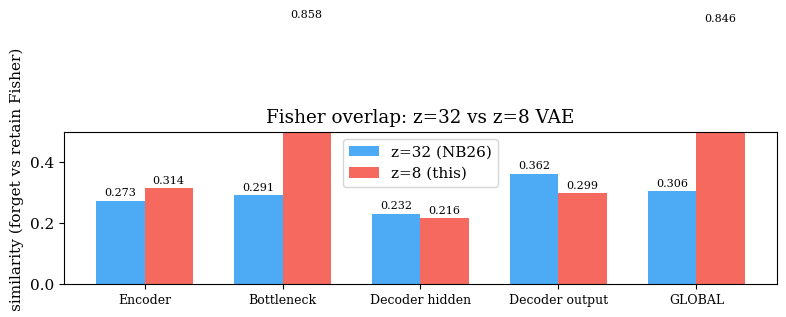

Saved to ../figures/fisher_z32_vs_z8.png


In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

cat_names = ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output', 'GLOBAL']

z32_vals = [
    baseline['vae']['per_category']['Encoder']['cosine'],
    baseline['vae']['per_category']['Bottleneck']['cosine'],
    baseline['vae']['per_category']['Decoder hidden']['cosine'],
    baseline['vae']['per_category']['Decoder output']['cosine'],
    baseline['vae']['global_cosine'],
]
z8_vals = [
    cat_results['Encoder']['cosine'],
    cat_results['Bottleneck']['cosine'],
    cat_results['Decoder hidden']['cosine'],
    cat_results['Decoder output']['cosine'],
    global_cos,
]

x = np.arange(len(cat_names))
w = 0.35

bars1 = ax.bar(x - w/2, z32_vals, w, label='z=32 (NB26)', color='#2196F3', alpha=0.8)
bars2 = ax.bar(x + w/2, z8_vals, w, label='z=8 (this)', color='#F44336', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(cat_names, fontsize=9)
ax.set_ylabel('Cosine similarity (forget vs retain Fisher)')
ax.set_title('Fisher overlap: z=32 vs z=8 VAE')
ax.legend()
ax.set_ylim(0, 0.5)

# Value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.008,
                f'{h:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_z32_vs_z8.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "fisher_z32_vs_z8.png"}')

## 12. Save results

In [13]:
results = {
    'global_cosine': global_cos,
    'log_fisher_correlation': log_corr,
    'top_1pct_overlap': top1,
    'top_10pct_overlap': top10,
    'total_params': n_total,
    'global_eff_rank_forget': effective_rank(ff_global),
    'global_eff_rank_retain': effective_rank(fr_global),
    'per_category': cat_results,
    'per_layer': layer_data,
    'val_loss': best_val_loss,
    'metadata': {
        'latent_dim': 8,
        'hidden_dims': [1024, 512, 128],
        'n_forget': len(forget_idx),
        'n_retain': len(retain_idx),
        'damping': 1e-8,
        'epochs': 100,
        'best_epoch': best_epoch,
        'lr': 1e-3,
        'seed': 42,
        'elapsed_seconds': elapsed,
    }
}

out_path = OUTPUTS / 'p6' / 'fisher_overlap_z8.json'
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2, default=float)
print(f'Results saved to {out_path}')
print()
print('=== Summary ===')
print(f'VAE z=8 global cosine:  {global_cos:.4f}')
print(f'VAE z=32 global cosine: {b_cos:.4f}')
print(f'Difference:             {global_cos - b_cos:+.4f}')

Results saved to ../outputs/p6/fisher_overlap_z8.json

=== Summary ===
VAE z=8 global cosine:  0.8463
VAE z=32 global cosine: 0.3058
Difference:             +0.5405
